# FullClass-TrainCNN(InceptionV3)_NoFreezModel_No-ClassImbalance

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

## Training Set DIR

In [2]:
train_dataset_path='D:/DatasetMedicalWasteCropped/'

In [3]:
#train_dataset_path='D:/DatasetMedicalWasteCroppedBalanced/'

## Testing Set DIR

In [4]:
test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

In [5]:
img_height=456
img_width=456
batch_size=64

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 3095 files for training.


In [7]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']
number of class = 41


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 773 files for validation.


In [9]:
test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1794 files belonging to 41 classes.


In [10]:
test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3140 files belonging to 41 classes.


In [11]:
test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2206 files belonging to 41 classes.


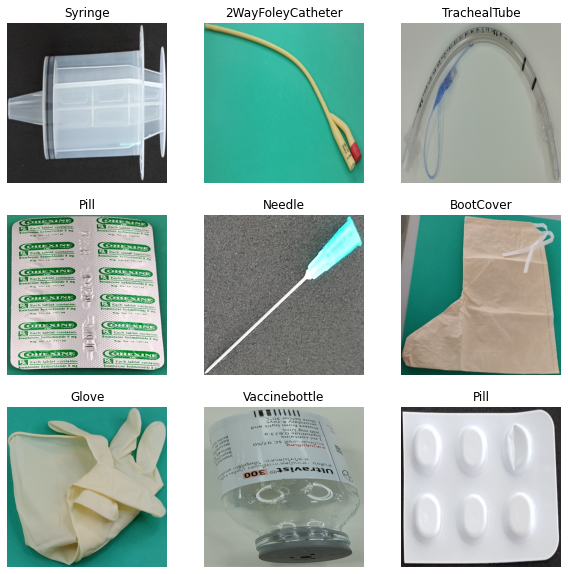

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Augmentation

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("vertical"),
  layers.RandomRotation(0.100),
  layers.RandomZoom(height_factor=0.025,width_factor=0.025),
  #layers.RandomContrast(0.300),
])

In [14]:
normalization_layer = layers.Rescaling(1./255)

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  # ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

In [16]:
# Test -> Fetching Mini Batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 456, 456, 3)
(64,)


In [17]:
'''
vgg16_model = keras.applications.vgg16.VGG16()
model = Sequential()

for layer in vgg16_model.layers[:-1]: # this is where I changed your code
    model.add(layer)    

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))
'''
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import EfficientNetB5

efficientnetB0_model = keras.applications.EfficientNetB5(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet",classifier_activation="softmax")

efficientnetB0_model_nooutput = efficientnetB0_model.layers[-3].output
custom_efficientnetB0_model = Model(inputs = efficientnetB0_model.input, outputs = efficientnetB0_model_nooutput)


123478016/123465288 [==============================] - 59s 0us/step


## Freez Extractor+

In [18]:
custom_efficientnetB0_model.trainable = False
for layer in custom_efficientnetB0_model.layers:
    layer.trainable = False
## Freez
#custom_inceptionv3_model.layers[-1].trainable = True
#custom_inceptionv3_model.layers[-2].trainable = True
#custom_inceptionv3_model.layers[-3].trainable = True
print(custom_efficientnetB0_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 456, 456, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 456, 456, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 456, 456, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 457, 457, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [19]:
#tf.keras.utils.plot_model(custom_efficientnetB0_model, to_file="InceptionRemoveOutput.png", show_shapes=True)

In [20]:
model = tf.keras.Sequential()
# Feature Extractor
model.add(custom_efficientnetB0_model)
# Classifier
#DeepDense
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax', trainable=True))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              28513527  
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 41)                42025     
Total params: 30,653,728
Trainable params: 2,140,201
Non-trainable params: 28,513,527
_________________________________________________________________


In [1]:
class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

In [23]:
#model.layers[-1]._name = 'Classifier'
#model.layers[-2]._name = 'InceptionV3'
#print(len(model.layers))
#tf.keras.utils.plot_model(model, to_file="Incepv3_FreezExtractorOurOutputLayer.png", show_shapes=True)

# Fitting

In [1]:
path_to_model = 'D:/ModelMedicalWasteCheckpoint/EfficientNetB5_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/'

In [25]:
EPOCHS = 2000
save_model_interval = 200
checkpoint_filepath = path_to_model+'OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch{epoch:04d}.pb' # -val_acc{val_accuracy:.2f}
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    period=save_model_interval,
    save_best_only=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.00001,cooldown=1, verbose=1)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback,reduce_lr])

Epoch 1/2000
49/49 [==============================] - 114s 2s/step - loss: 0.9661 - accuracy: 0.7422 - val_loss: 0.2008 - val_accuracy: 0.9457
Epoch 2/2000
49/49 [==============================] - 68s 1s/step - loss: 0.1503 - accuracy: 0.9638 - val_loss: 0.1154 - val_accuracy: 0.9677
Epoch 3/2000
49/49 [==============================] - 68s 1s/step - loss: 0.0700 - accuracy: 0.9851 - val_loss: 0.0687 - val_accuracy: 0.9858
Epoch 4/2000
49/49 [==============================] - 68s 1s/step - loss: 0.0393 - accuracy: 0.9935 - val_loss: 0.0653 - val_accuracy: 0.9845
Epoch 5/2000
49/49 [==============================] - 68s 1s/step - loss: 0.0299 - accuracy: 0.9948 - val_loss: 0.0584 - val_accuracy: 0.9832
Epoch 6/2000
49/49 [==============================] - 68s 1s/step - loss: 0.0265 - accuracy: 0.9939 - val_loss: 0.0606 - val_accuracy: 0.9832
Epoch 7/2000
49/49 [==============================] - 68s 1s/step - loss: 0.0153 - accuracy: 0.9977 - val_loss: 0.0512 - val_accuracy: 0.9884
Epoch

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 201/2000
49/49 [==============================] - 69s 1s/step - loss: 6.0342e-04 - accuracy: 1.0000 - val_loss: 0.0334 - val_accuracy: 0.9909
Epoch 202/2000
49/49 [==============================] - 68s 1s/step - loss: 6.0870e-04 - accuracy: 1.0000 - val_loss: 0.0330 - val_accuracy: 0.9909
Epoch 203/2000
49/49 [==============================] - 68s 1s/step - loss: 7.5636e-04 - accuracy: 1.0000 - val_loss: 0.0323 - val_accuracy: 0.9909
Epoch 204/2000
49/49 [==============================] - 68s 1s/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.0303 - val_accuracy: 0.9922
Epoch 205/2000
49/49 [==============================] - 68s 1s/step - loss: 5.9093e-04 - accuracy: 1.0000 - val_loss: 0.0303 - val_accuracy: 0.9922
Epoch 206/2000
49/49 [==============================] - 68s 1s/step - loss: 6.0307e-04 - accuracy: 1.0000 - val_loss: 0.0307 - val_accuracy: 0.9935
Epoch 207/2000
49/49 [==============================] - 68s 1s/step - loss: 6.3947e-04 - accuracy: 1.0000 - val_loss

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 401/2000
49/49 [==============================] - 68s 1s/step - loss: 2.8782e-04 - accuracy: 1.0000 - val_loss: 0.0300 - val_accuracy: 0.9948
Epoch 402/2000
49/49 [==============================] - 68s 1s/step - loss: 3.6591e-04 - accuracy: 1.0000 - val_loss: 0.0300 - val_accuracy: 0.9948
Epoch 403/2000
49/49 [==============================] - 68s 1s/step - loss: 5.7335e-04 - accuracy: 1.0000 - val_loss: 0.0310 - val_accuracy: 0.9935
Epoch 404/2000
49/49 [==============================] - 68s 1s/step - loss: 2.8385e-04 - accuracy: 1.0000 - val_loss: 0.0315 - val_accuracy: 0.9935
Epoch 405/2000
49/49 [==============================] - 68s 1s/step - loss: 2.8542e-04 - accuracy: 1.0000 - val_loss: 0.0319 - val_accuracy: 0.9935
Epoch 406/2000
49/49 [==============================] - 68s 1s/step - loss: 3.3308e-04 - accuracy: 1.0000 - val_loss: 0.0310 - val_accuracy: 0.9922
Epoch 407/2000
49/49 [==============================] - 68s 1s/step - loss: 4.4345e-04 - accuracy: 1.0000 - val_

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 601/2000
49/49 [==============================] - 68s 1s/step - loss: 1.7273e-04 - accuracy: 1.0000 - val_loss: 0.0283 - val_accuracy: 0.9935
Epoch 602/2000
49/49 [==============================] - 68s 1s/step - loss: 1.9771e-04 - accuracy: 1.0000 - val_loss: 0.0288 - val_accuracy: 0.9948
Epoch 603/2000
49/49 [==============================] - 68s 1s/step - loss: 1.5382e-04 - accuracy: 1.0000 - val_loss: 0.0290 - val_accuracy: 0.9935
Epoch 604/2000
49/49 [==============================] - 68s 1s/step - loss: 1.7571e-04 - accuracy: 1.0000 - val_loss: 0.0300 - val_accuracy: 0.9935
Epoch 605/2000
49/49 [==============================] - 68s 1s/step - loss: 1.0820e-04 - accuracy: 1.0000 - val_loss: 0.0300 - val_accuracy: 0.9935
Epoch 606/2000
49/49 [==============================] - 68s 1s/step - loss: 1.3223e-04 - accuracy: 1.0000 - val_loss: 0.0296 - val_accuracy: 0.9935
Epoch 607/2000
49/49 [==============================] - 68s 1s/step - loss: 1.2157e-04 - accuracy: 1.0000 - val_

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 801/2000
49/49 [==============================] - 68s 1s/step - loss: 6.9402e-05 - accuracy: 1.0000 - val_loss: 0.0303 - val_accuracy: 0.9948
Epoch 802/2000
49/49 [==============================] - 68s 1s/step - loss: 7.9612e-05 - accuracy: 1.0000 - val_loss: 0.0305 - val_accuracy: 0.9948
Epoch 803/2000
49/49 [==============================] - 68s 1s/step - loss: 9.0890e-05 - accuracy: 1.0000 - val_loss: 0.0311 - val_accuracy: 0.9948
Epoch 804/2000
49/49 [==============================] - 68s 1s/step - loss: 6.8210e-05 - accuracy: 1.0000 - val_loss: 0.0312 - val_accuracy: 0.9948
Epoch 805/2000
49/49 [==============================] - 68s 1s/step - loss: 8.0966e-05 - accuracy: 1.0000 - val_loss: 0.0312 - val_accuracy: 0.9948
Epoch 806/2000
49/49 [==============================] - 68s 1s/step - loss: 9.1905e-05 - accuracy: 1.0000 - val_loss: 0.0310 - val_accuracy: 0.9948
Epoch 807/2000
49/49 [==============================] - 68s 1s/step - loss: 8.1269e-05 - accuracy: 1.0000 - val_

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1001/2000
49/49 [==============================] - 69s 1s/step - loss: 4.8301e-05 - accuracy: 1.0000 - val_loss: 0.0304 - val_accuracy: 0.9948
Epoch 1002/2000
49/49 [==============================] - 69s 1s/step - loss: 5.2250e-05 - accuracy: 1.0000 - val_loss: 0.0301 - val_accuracy: 0.9948
Epoch 1003/2000
49/49 [==============================] - 69s 1s/step - loss: 9.1851e-05 - accuracy: 1.0000 - val_loss: 0.0300 - val_accuracy: 0.9948
Epoch 1004/2000
49/49 [==============================] - 69s 1s/step - loss: 4.7468e-05 - accuracy: 1.0000 - val_loss: 0.0299 - val_accuracy: 0.9948
Epoch 1005/2000
49/49 [==============================] - 68s 1s/step - loss: 5.5475e-05 - accuracy: 1.0000 - val_loss: 0.0299 - val_accuracy: 0.9948
Epoch 1006/2000
49/49 [==============================] - 68s 1s/step - loss: 4.8999e-05 - accuracy: 1.0000 - val_loss: 0.0298 - val_accuracy: 0.9948
Epoch 1007/2000
49/49 [==============================] - 69s 1s/step - loss: 4.2705e-05 - accuracy: 1.0000

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1201/2000
49/49 [==============================] - 69s 1s/step - loss: 3.4251e-05 - accuracy: 1.0000 - val_loss: 0.0296 - val_accuracy: 0.9948
Epoch 1202/2000
49/49 [==============================] - 68s 1s/step - loss: 3.4579e-05 - accuracy: 1.0000 - val_loss: 0.0293 - val_accuracy: 0.9948
Epoch 1203/2000
49/49 [==============================] - 68s 1s/step - loss: 1.1236e-04 - accuracy: 1.0000 - val_loss: 0.0294 - val_accuracy: 0.9948
Epoch 1204/2000
49/49 [==============================] - 68s 1s/step - loss: 5.4839e-05 - accuracy: 1.0000 - val_loss: 0.0297 - val_accuracy: 0.9935
Epoch 1205/2000
49/49 [==============================] - 68s 1s/step - loss: 2.8679e-05 - accuracy: 1.0000 - val_loss: 0.0296 - val_accuracy: 0.9948
Epoch 1206/2000
49/49 [==============================] - 68s 1s/step - loss: 4.5665e-05 - accuracy: 1.0000 - val_loss: 0.0295 - val_accuracy: 0.9948
Epoch 1207/2000
49/49 [==============================] - 68s 1s/step - loss: 4.4363e-05 - accuracy: 1.0000

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1401/2000
49/49 [==============================] - 68s 1s/step - loss: 2.9059e-05 - accuracy: 1.0000 - val_loss: 0.0316 - val_accuracy: 0.9948
Epoch 1402/2000
49/49 [==============================] - 68s 1s/step - loss: 4.1827e-05 - accuracy: 1.0000 - val_loss: 0.0315 - val_accuracy: 0.9948
Epoch 1403/2000
49/49 [==============================] - 68s 1s/step - loss: 2.8528e-05 - accuracy: 1.0000 - val_loss: 0.0316 - val_accuracy: 0.9948
Epoch 1404/2000
49/49 [==============================] - 68s 1s/step - loss: 3.5885e-05 - accuracy: 1.0000 - val_loss: 0.0315 - val_accuracy: 0.9948
Epoch 1405/2000
49/49 [==============================] - 68s 1s/step - loss: 1.9547e-05 - accuracy: 1.0000 - val_loss: 0.0314 - val_accuracy: 0.9948
Epoch 1406/2000
49/49 [==============================] - 68s 1s/step - loss: 2.1738e-05 - accuracy: 1.0000 - val_loss: 0.0314 - val_accuracy: 0.9948
Epoch 1407/2000
49/49 [==============================] - 68s 1s/step - loss: 3.5962e-05 - accuracy: 1.0000

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1601/2000
49/49 [==============================] - 68s 1s/step - loss: 1.4348e-05 - accuracy: 1.0000 - val_loss: 0.0321 - val_accuracy: 0.9948
Epoch 1602/2000
49/49 [==============================] - 68s 1s/step - loss: 2.4345e-05 - accuracy: 1.0000 - val_loss: 0.0326 - val_accuracy: 0.9948
Epoch 1603/2000
49/49 [==============================] - 68s 1s/step - loss: 2.5940e-05 - accuracy: 1.0000 - val_loss: 0.0325 - val_accuracy: 0.9948
Epoch 1604/2000
49/49 [==============================] - 68s 1s/step - loss: 1.1115e-04 - accuracy: 1.0000 - val_loss: 0.0324 - val_accuracy: 0.9948
Epoch 1605/2000
49/49 [==============================] - 68s 1s/step - loss: 2.4260e-05 - accuracy: 1.0000 - val_loss: 0.0323 - val_accuracy: 0.9948
Epoch 1606/2000
49/49 [==============================] - 68s 1s/step - loss: 2.8527e-05 - accuracy: 1.0000 - val_loss: 0.0323 - val_accuracy: 0.9948
Epoch 1607/2000
49/49 [==============================] - 68s 1s/step - loss: 1.9554e-05 - accuracy: 1.0000

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1801/2000
49/49 [==============================] - 68s 1s/step - loss: 1.2477e-05 - accuracy: 1.0000 - val_loss: 0.0336 - val_accuracy: 0.9935
Epoch 1802/2000
49/49 [==============================] - 68s 1s/step - loss: 2.0430e-05 - accuracy: 1.0000 - val_loss: 0.0336 - val_accuracy: 0.9935
Epoch 1803/2000
49/49 [==============================] - 68s 1s/step - loss: 1.2026e-05 - accuracy: 1.0000 - val_loss: 0.0336 - val_accuracy: 0.9935
Epoch 1804/2000
49/49 [==============================] - 68s 1s/step - loss: 6.6121e-05 - accuracy: 1.0000 - val_loss: 0.0360 - val_accuracy: 0.9922
Epoch 1805/2000
49/49 [==============================] - 68s 1s/step - loss: 2.0550e-05 - accuracy: 1.0000 - val_loss: 0.0358 - val_accuracy: 0.9922
Epoch 1806/2000
49/49 [==============================] - 68s 1s/step - loss: 1.9847e-05 - accuracy: 1.0000 - val_loss: 0.0354 - val_accuracy: 0.9935
Epoch 1807/2000
49/49 [==============================] - 68s 1s/step - loss: 1.7173e-05 - accuracy: 1.0000

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Text(0.5, 1.0, 'Training and Validation Accuracy')

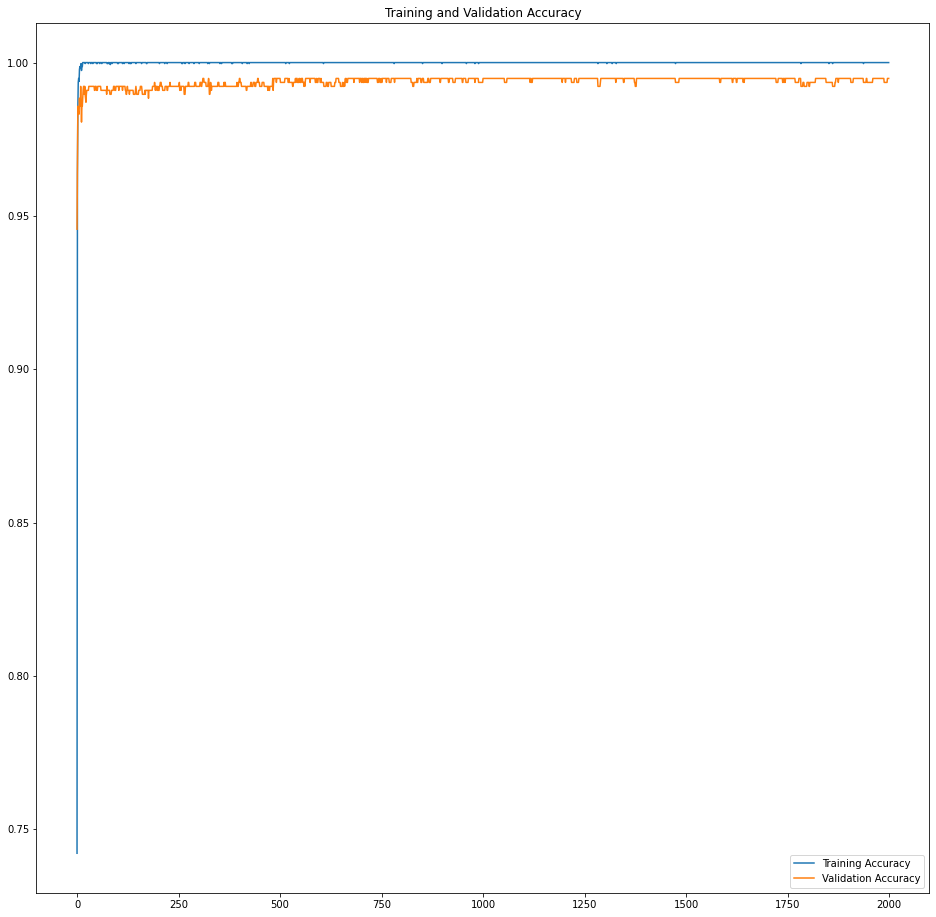

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


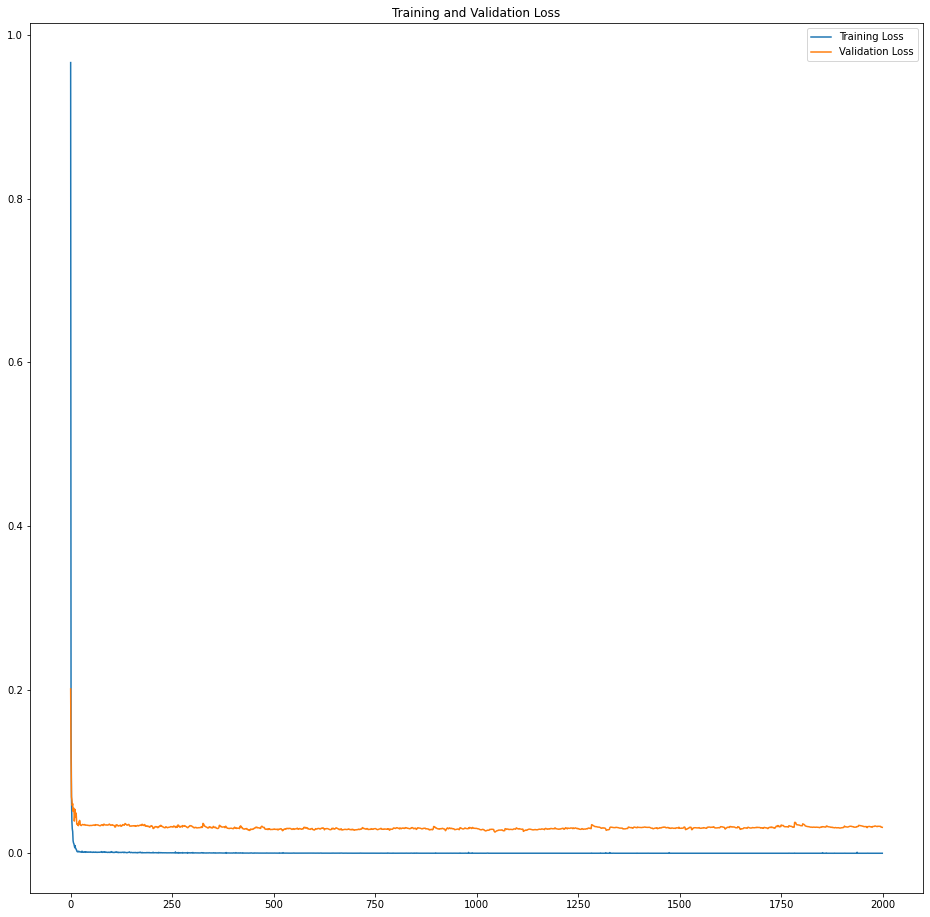

In [27]:
#plt.subplot(1, 2, 2)
plt.figure(figsize=(16, 16))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
#indoor testset
test_indoor_ds_results = model.evaluate(test_indoor_ds)
print("test_indoor_ds_results:test loss, test acc:", test_indoor_ds_results)

29/29 [==============================] - 37s 1s/step - loss: 0.3430 - accuracy: 0.9326
test_indoor_ds_results:test loss, test acc: [0.3430379331111908, 0.9325529336929321]


In [29]:
#outdoor testset
test_outdoor_ds_results = model.evaluate(test_outdoor_ds)
print("test_outdoor_ds_results:test loss, test acc:", test_outdoor_ds_results)

50/50 [==============================] - 61s 1s/step - loss: 0.5368 - accuracy: 0.8834
test_outdoor_ds_results:test loss, test acc: [0.536771297454834, 0.8834394812583923]


In [30]:
#belt testset
test_belt_ds_results = model.evaluate(test_belt_ds)
print("test_belt_ds_results:test loss, test acc:", test_belt_ds_results)

35/35 [==============================] - 42s 1s/step - loss: 1.4519 - accuracy: 0.7634
test_belt_ds_results:test loss, test acc: [1.451857566833496, 0.7633726000785828]


In [31]:
# Read path of trained model
import os, os.path
trained_path = path_to_model
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths

['D:/ModelMedicalWasteCheckpoint/EfficientNetB5_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0200.pb',
 'D:/ModelMedicalWasteCheckpoint/EfficientNetB5_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0400.pb',
 'D:/ModelMedicalWasteCheckpoint/EfficientNetB5_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0600.pb',
 'D:/ModelMedicalWasteCheckpoint/EfficientNetB5_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0800.pb',
 'D:/ModelMedicalWasteCheckpoint/EfficientNetB5_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/OurOutputLayer_DeepDense-NoCl

# Testing in testset

In [32]:
test_indoor_acc = []
test_outdoor_acc = []
test_belt_acc = []
test_indoor_loss = []
test_outdoor_loss = []
test_belt_loss = []

for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    #indoor
    test_indoor_results = loaded_model.evaluate(test_indoor_ds)
    test_indoor_loss.append(test_indoor_results[0]) # append loss
    test_indoor_acc.append(test_indoor_results[1]) # append acc
    #outdoor
    test_outdoor_results = loaded_model.evaluate(test_outdoor_ds)
    test_outdoor_loss.append(test_outdoor_results[0]) # append loss
    test_outdoor_acc.append(test_outdoor_results[1]) # append acc
    #belt
    test_belt_results = loaded_model.evaluate(test_belt_ds)
    test_belt_loss.append(test_belt_results[0]) # append loss
    test_belt_acc.append(test_belt_results[1]) # append acc
    # printout
    lm_idx_show = (lm_idx+1) * save_model_interval
    print(f"Epoch{lm_idx_show:03d} \n test_indoor_acc={test_indoor_acc[lm_idx]} \n test_outdoor_acc={test_outdoor_acc[lm_idx]} \n test_belt_acc={test_belt_acc[lm_idx]}")

35/35 [==============================] - 38s 1s/step - loss: 1.1274 - accuracy: 0.7430
Epoch200 
 test_indoor_acc=0.9286510348320007 
 test_outdoor_acc=0.8815286755561829 
 test_belt_acc=0.7429736852645874


35/35 [==============================] - 38s 1s/step - loss: 1.1816 - accuracy: 0.7520
Epoch400 
 test_indoor_acc=0.931438148021698 
 test_outdoor_acc=0.8840764164924622 
 test_belt_acc=0.752039909362793


35/35 [==============================] - 38s 1s/step - loss: 1.2442 - accuracy: 0.7516
Epoch600 
 test_indoor_acc=0.9319955110549927 
 test_outdoor_acc=0.8821656107902527 
 test_belt_acc=0.7515865564346313


35/35 [==============================] - 39s 1s/step - loss: 1.2958 - accuracy: 0.7566
Epoch800 
 test_indoor_acc=0.9308807253837585 
 test_outdoor_acc=0.8805732727050781 
 test_belt_acc=0.756572961807251


35/35 [==============================] - 38s 1s/step - loss: 1.3512 - accuracy: 0.7557
Epoch1000 
 test_indoor_acc=0.933667778968811 
 test_outdoor_acc=0.8866242170333862 
 test_belt_acc=0.7556663751602173


35/35 [==============================] - 38s 1s/step - loss: 1.3647 - accuracy: 0.7620
Epoch1200 
 test_indoor_acc=0.9319955110549927 
 test_outdoor_acc=0.8859872817993164 
 test_belt_acc=0.7620127201080322


35/35 [==============================] - 38s 1s/step - loss: 1.4260 - accuracy: 0.7584
Epoch1400 
 test_indoor_acc=0.9347826242446899 
 test_outdoor_acc=0.8828025460243225 
 test_belt_acc=0.7583861947059631


35/35 [==============================] - 38s 1s/step - loss: 1.4192 - accuracy: 0.7593
Epoch1600 
 test_indoor_acc=0.9286510348320007 
 test_outdoor_acc=0.8837579488754272 
 test_belt_acc=0.7592928409576416


35/35 [==============================] - 38s 1s/step - loss: 1.4236 - accuracy: 0.7643
Epoch1800 
 test_indoor_acc=0.9364548325538635 
 test_outdoor_acc=0.8866242170333862 
 test_belt_acc=0.7642792463302612


35/35 [==============================] - 38s 1s/step - loss: 1.4519 - accuracy: 0.7634
Epoch2000 
 test_indoor_acc=0.9325529336929321 
 test_outdoor_acc=0.8834394812583923 
 test_belt_acc=0.7633726000785828


In [33]:
#Average
test_avg_acc = []
for i in range(len(test_indoor_acc)):
    tmp_avg = (test_indoor_acc[i] + test_outdoor_acc[i] + test_belt_acc[i]) / 3.0
    test_avg_acc.append(tmp_avg)
    

range(200, 2200, 200)


Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

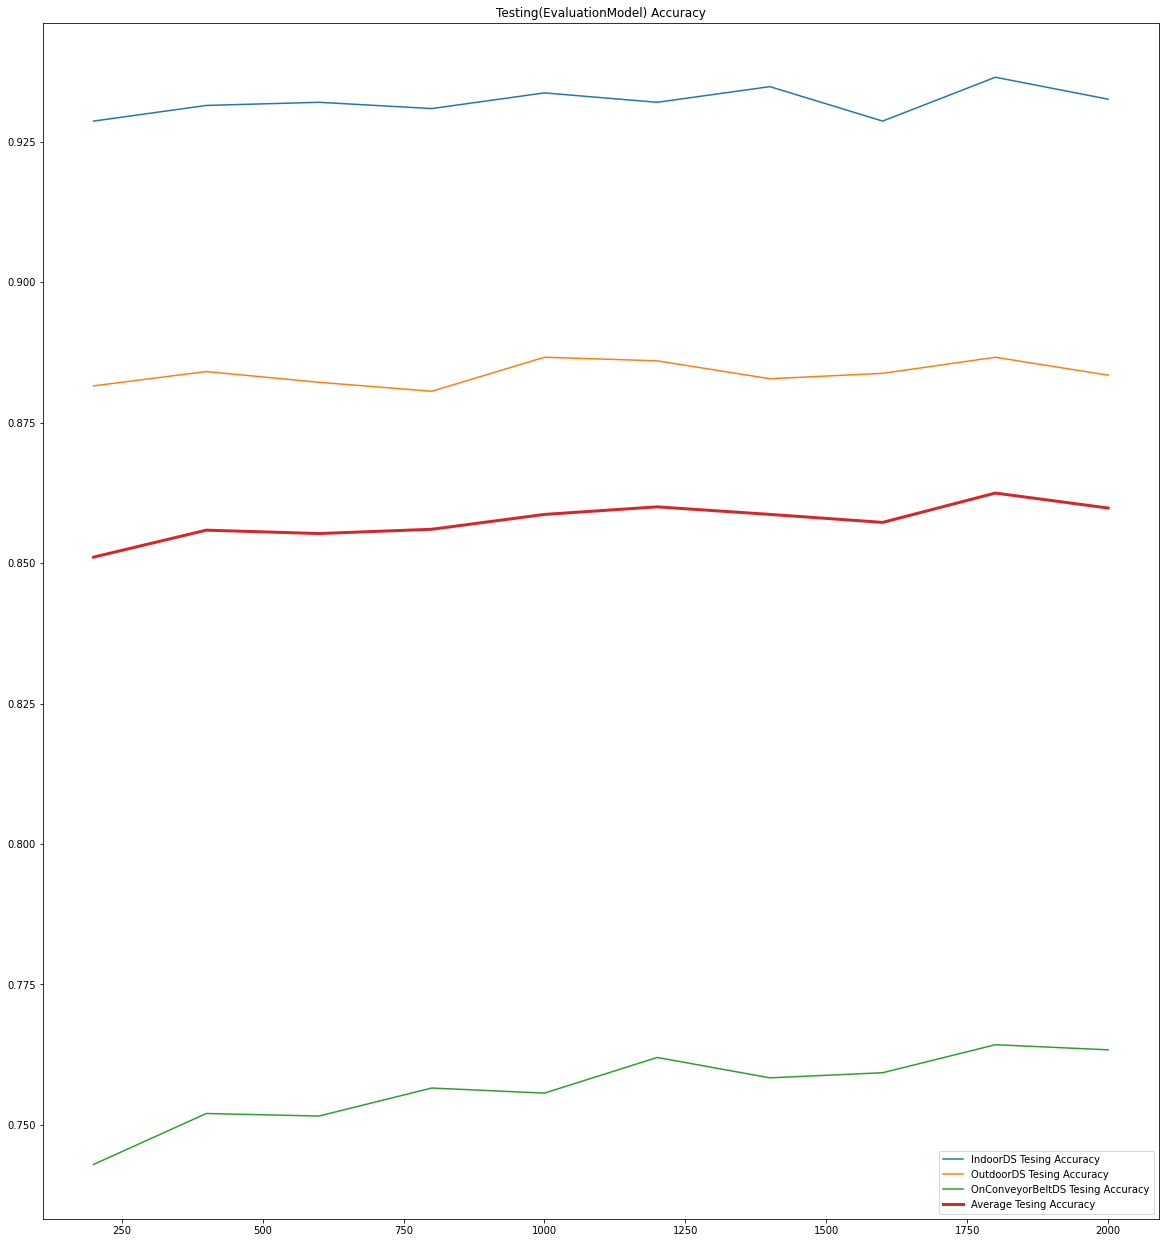

In [34]:
# loss / acc in each epoch graph ploting
#EPOCHS = 400
import matplotlib.pyplot as plt
epochs_range = range(save_model_interval,EPOCHS+save_model_interval,save_model_interval)
print(epochs_range)
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_indoor_acc, label='IndoorDS Tesing Accuracy')
plt.plot(epochs_range, test_outdoor_acc, label='OutdoorDS Tesing Accuracy')
plt.plot(epochs_range, test_belt_acc, label='OnConveyorBeltDS Tesing Accuracy')
plt.plot(epochs_range, test_avg_acc, label='Average Tesing Accuracy',linewidth=3)
plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')

### Max acc

In [35]:
#Find Max Index and Value
print(f"max acc -> {max(test_avg_acc)}")
max_index = test_avg_acc.index(max(test_avg_acc))
print(f"max index -> {max_index}")
print(f"The [Epoch] of max acc -> {(max_index+1)*save_model_interval}")

max acc -> 0.862452765305837
max index -> 8
The [Epoch] of max acc -> 1800


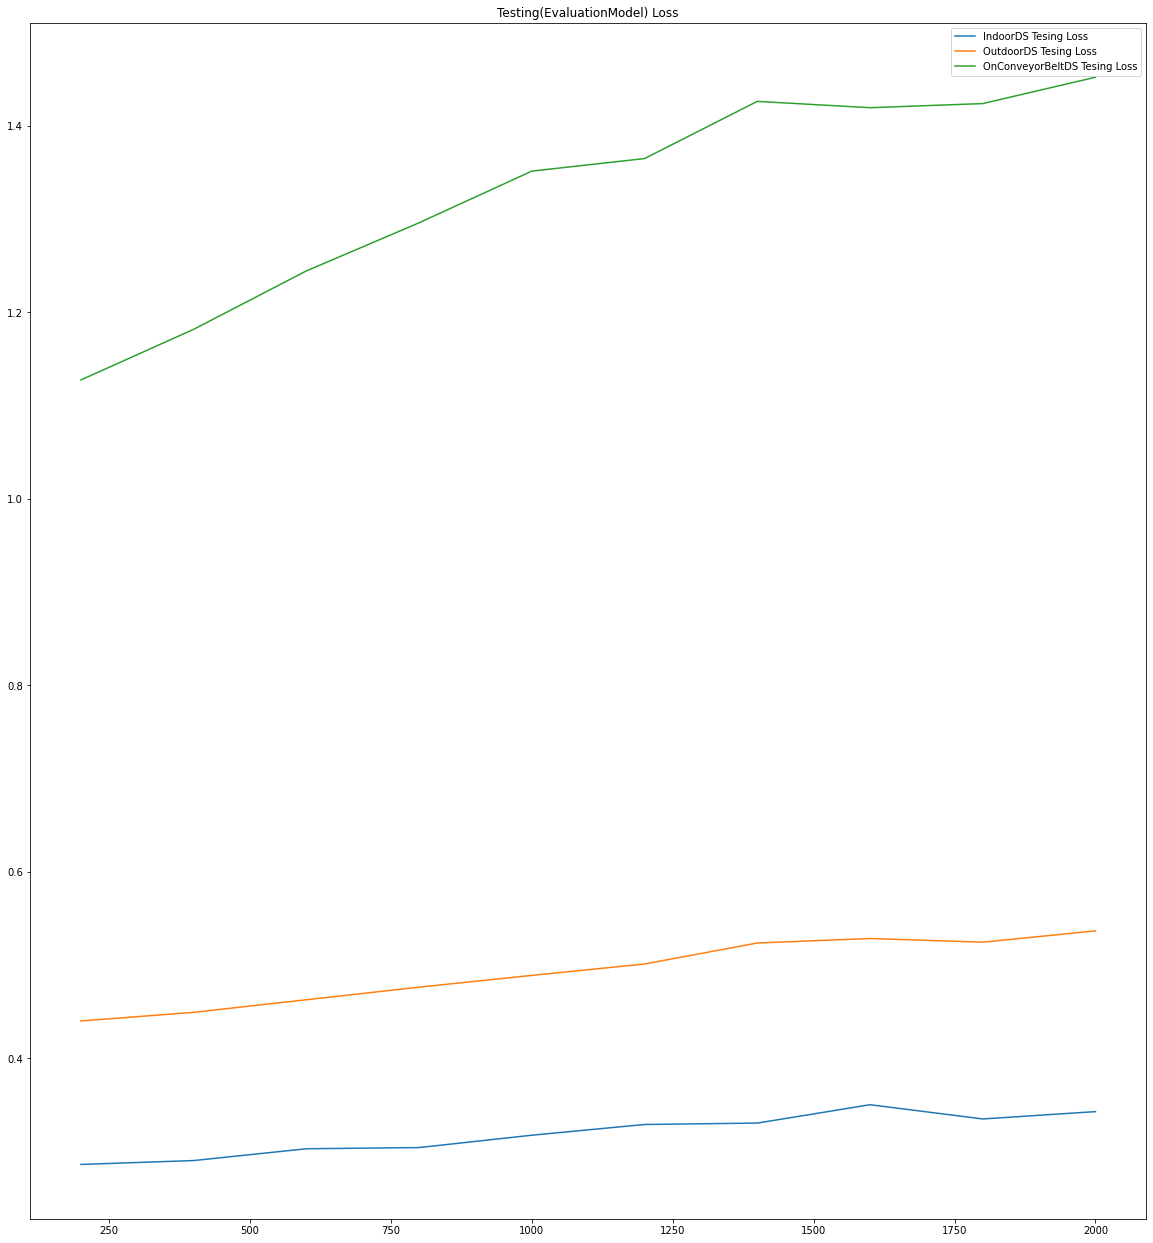

In [36]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_indoor_loss, label='IndoorDS Tesing Loss')
plt.plot(epochs_range, test_outdoor_loss, label='OutdoorDS Tesing Loss')
plt.plot(epochs_range, test_belt_loss, label='OnConveyorBeltDS Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [37]:
test_indoor_acc

[0.9286510348320007,
 0.931438148021698,
 0.9319955110549927,
 0.9308807253837585,
 0.933667778968811,
 0.9319955110549927,
 0.9347826242446899,
 0.9286510348320007,
 0.9364548325538635,
 0.9325529336929321]

In [38]:
test_outdoor_acc

[0.8815286755561829,
 0.8840764164924622,
 0.8821656107902527,
 0.8805732727050781,
 0.8866242170333862,
 0.8859872817993164,
 0.8828025460243225,
 0.8837579488754272,
 0.8866242170333862,
 0.8834394812583923]

In [39]:
test_belt_acc

[0.7429736852645874,
 0.752039909362793,
 0.7515865564346313,
 0.756572961807251,
 0.7556663751602173,
 0.7620127201080322,
 0.7583861947059631,
 0.7592928409576416,
 0.7642792463302612,
 0.7633726000785828]

In [40]:
test_indoor_loss

[0.2864094078540802,
 0.29056885838508606,
 0.3032180666923523,
 0.304511159658432,
 0.31773847341537476,
 0.32924017310142517,
 0.3307468295097351,
 0.3504289388656616,
 0.3351728320121765,
 0.3430379331111908]

In [41]:
test_outdoor_loss

[0.44019022583961487,
 0.44946184754371643,
 0.4629509150981903,
 0.4764595925807953,
 0.48905709385871887,
 0.5012713074684143,
 0.5237743854522705,
 0.5286232829093933,
 0.5246577858924866,
 0.536771297454834]

In [42]:
test_belt_loss

[1.1273669004440308,
 1.1816259622573853,
 1.2442373037338257,
 1.295845866203308,
 1.3512263298034668,
 1.3646775484085083,
 1.4259716272354126,
 1.419201135635376,
 1.4236317873001099,
 1.451857566833496]

## Load Last Epoch and test in each class

In [57]:
# Del dataset memory and reload
# RAM
del train_ds
del val_ds
del test_indoor_ds
del test_outdoor_ds
del test_belt_ds
# VRAM
#from numba import cuda
#cuda.select_device(0)
#cuda.close()

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

last_epoch_model = tf.keras.models.load_model(path_to_model+'OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch1800.pb')

test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

img_height=456
img_width=456
batch_size=2

test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  #ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

x_test_indoor = np.concatenate([ x for x,y in test_indoor_ds],axis=0)
x_test_outdoor = np.concatenate([ x for x,y in test_outdoor_ds],axis=0)
x_test_belt = np.concatenate([ x for x,y in test_belt_ds],axis=0)
y_test_indoor = np.concatenate([ y for x,y in test_indoor_ds],axis=0)
y_test_outdoor = np.concatenate([ y for x,y in test_outdoor_ds],axis=0)
y_test_belt = np.concatenate([ y for x,y in test_belt_ds],axis=0)
print(f"train_indoor num x,y : {len(x_test_indoor)},{len(y_test_indoor)}")
print(f"train_outdoor num x,y : {len(x_test_outdoor)},{len(y_test_outdoor)}")
print(f"train_belt num x,y : {len(x_test_belt)},{len(y_test_belt)}")
x_all = np.concatenate([x_test_indoor,x_test_outdoor,x_test_belt],axis=0)
y_all = np.concatenate([y_test_indoor,y_test_outdoor,y_test_belt],axis=0)
print(f"all num x,y :{len(x_all)},{len(y_all)}")
# let's predict
### VRAM not enough -> we split into N set
del x_test_indoor,x_test_outdoor,x_test_belt
N = 100
x_all_sets = np.array_split(x_all, N)
del x_all
y_all_sets_predicted = []
for idx,x in enumerate(x_all_sets):
  print(f"process in chunk {idx+1}/{N}")
  y_all_sets_predicted.append(last_epoch_model.predict(x,batch_size=2))
y_all_predicted = np.concatenate(y_all_sets_predicted)

Found 1794 files belonging to 41 classes.
Found 3140 files belonging to 41 classes.
Found 2206 files belonging to 41 classes.
train_indoor num x,y : 1794,1794
train_outdoor num x,y : 3140,3140
train_belt num x,y : 2206,2206
all num x,y :7140,7140
process in chunk 0/100
process in chunk 1/100
process in chunk 2/100
process in chunk 3/100
process in chunk 4/100
process in chunk 5/100
process in chunk 6/100
process in chunk 7/100
process in chunk 8/100
process in chunk 9/100
process in chunk 10/100
process in chunk 11/100
process in chunk 12/100
process in chunk 13/100
process in chunk 14/100
process in chunk 15/100
process in chunk 16/100
process in chunk 17/100
process in chunk 18/100
process in chunk 19/100
process in chunk 20/100
process in chunk 21/100
process in chunk 22/100
process in chunk 23/100
process in chunk 24/100
process in chunk 25/100
process in chunk 26/100
process in chunk 27/100
process in chunk 28/100
process in chunk 29/100
process in chunk 30/100
process in chunk 31

NameError: name 'x_all' is not defined

In [3]:
y_all_predicted_max = np.array([],dtype=np.int)
# acc all
TP = 0
FP = 0
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
    y_all_predicted_max=np.append(y_all_predicted_max,np.argmax(y_all_predicted[i]))
print(f'all={TP+FP}')
print(f'TP={TP}')
print(f'FP={FP}')
print(f'acc={TP/(TP+FP)}')

# acc eachclass
TP_eachclass = [0] * 41
FP_eachclass = [0] * 41
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_all[i]] = TP_eachclass[y_all[i]] + 1
    else :
        FP_eachclass[y_all[i]] = FP_eachclass[y_all[i]] + 1
#recheck
print(f'all check = {sum(TP_eachclass)+sum(FP_eachclass)}')

all=7140
TP=6150
FP=990
acc=0.8613445378151261
all check = 7140


### acc

In [4]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')


1WayConnectorforFoley acc = 87.93103448275862%
2WayConnectorforFoley acc = 95.91836734693877%
2WayFoleyCatheter acc = 73.13432835820896%
3WayConnectorforFoley acc = 98.29059829059828%
3Waystopcock acc = 99.09909909909909%
AlcoholBottle acc = 86.25%
AlcoholPad acc = 53.17460317460318%
BootCover acc = 63.25301204819277%
CottonBall acc = 98.80239520958084%
CottonSwap acc = 93.7062937062937%
Dilator acc = 84.61538461538461%
DisposableInfusionSet acc = 86.72566371681415%
ExtensionTube acc = 64.22764227642277%
FaceShield acc = 84.5679012345679%
FrontLoadSyringe acc = 63.716814159292035%
GauzePad acc = 67.61363636363636%
Glove acc = 84.22619047619048%
GuideWire acc = 64.28571428571429%
LiquidBottle acc = 86.25954198473282%
Mask acc = 98.96103896103897%
NGTube acc = 69.6774193548387%
NasalCannula acc = 46.017699115044245%
Needle acc = 91.42857142857143%
OxygenMask acc = 97.74436090225564%
PPESuit acc = 95.96774193548387%
PharmaceuticalProduct acc = 86.6822429906542%
Pill acc = 95.9383753501400

In [5]:
# for plotting
import matplotlib.pyplot as plt
# for using scikit-learn's built-in metrics
from sklearn.metrics import *
# for using tesnorflow/keras' built-in metrics
import tensorflow.keras.backend as K
''' ndarray of shape (n_classes, n_classes)
Confusion matrix whose i-th row and j-th column entry indicates the number of samples with  {true label being i-th row class} and {predicted label being column j-th class}.
> Example
>>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
>>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
>>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
พุดง่ายๆ แถวคือด้านความจริง
       หลักคือด้านที่ระบบทำนาย
'''
# 
confusionMat = confusion_matrix(y_all, y_all_predicted_max, labels=range(len(class_names)))
confusionMat

array([[102,   0,   0, ...,   0,   0,   0],
       [  0, 141,   0, ...,   0,   0,   1],
       [  0,   0,  98, ...,   3,   0,  15],
       ...,
       [  0,   0,   0, ..., 118,   0,   0],
       [  0,   0,   0, ...,   0, 197,   0],
       [  0,   0,   0, ...,   0,   0,  98]], dtype=int64)

In [6]:
confusionMatFloat = confusionMat.astype('float64')
confusionMatFloatPercent=confusionMatFloat/confusionMatFloat.sum(axis=1)[:,None]  # divided by number of sample in each class (sum of each row)
confusionMatFloatPercent*=100
confusionMatFloatPercent

array([[87.93103448,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 95.91836735,  0.        , ...,  0.        ,
         0.        ,  0.68027211],
       [ 0.        ,  0.        , 73.13432836, ...,  2.23880597,
         0.        , 11.19402985],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 98.33333333,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        92.48826291,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 85.96491228]])

<AxesSubplot:>

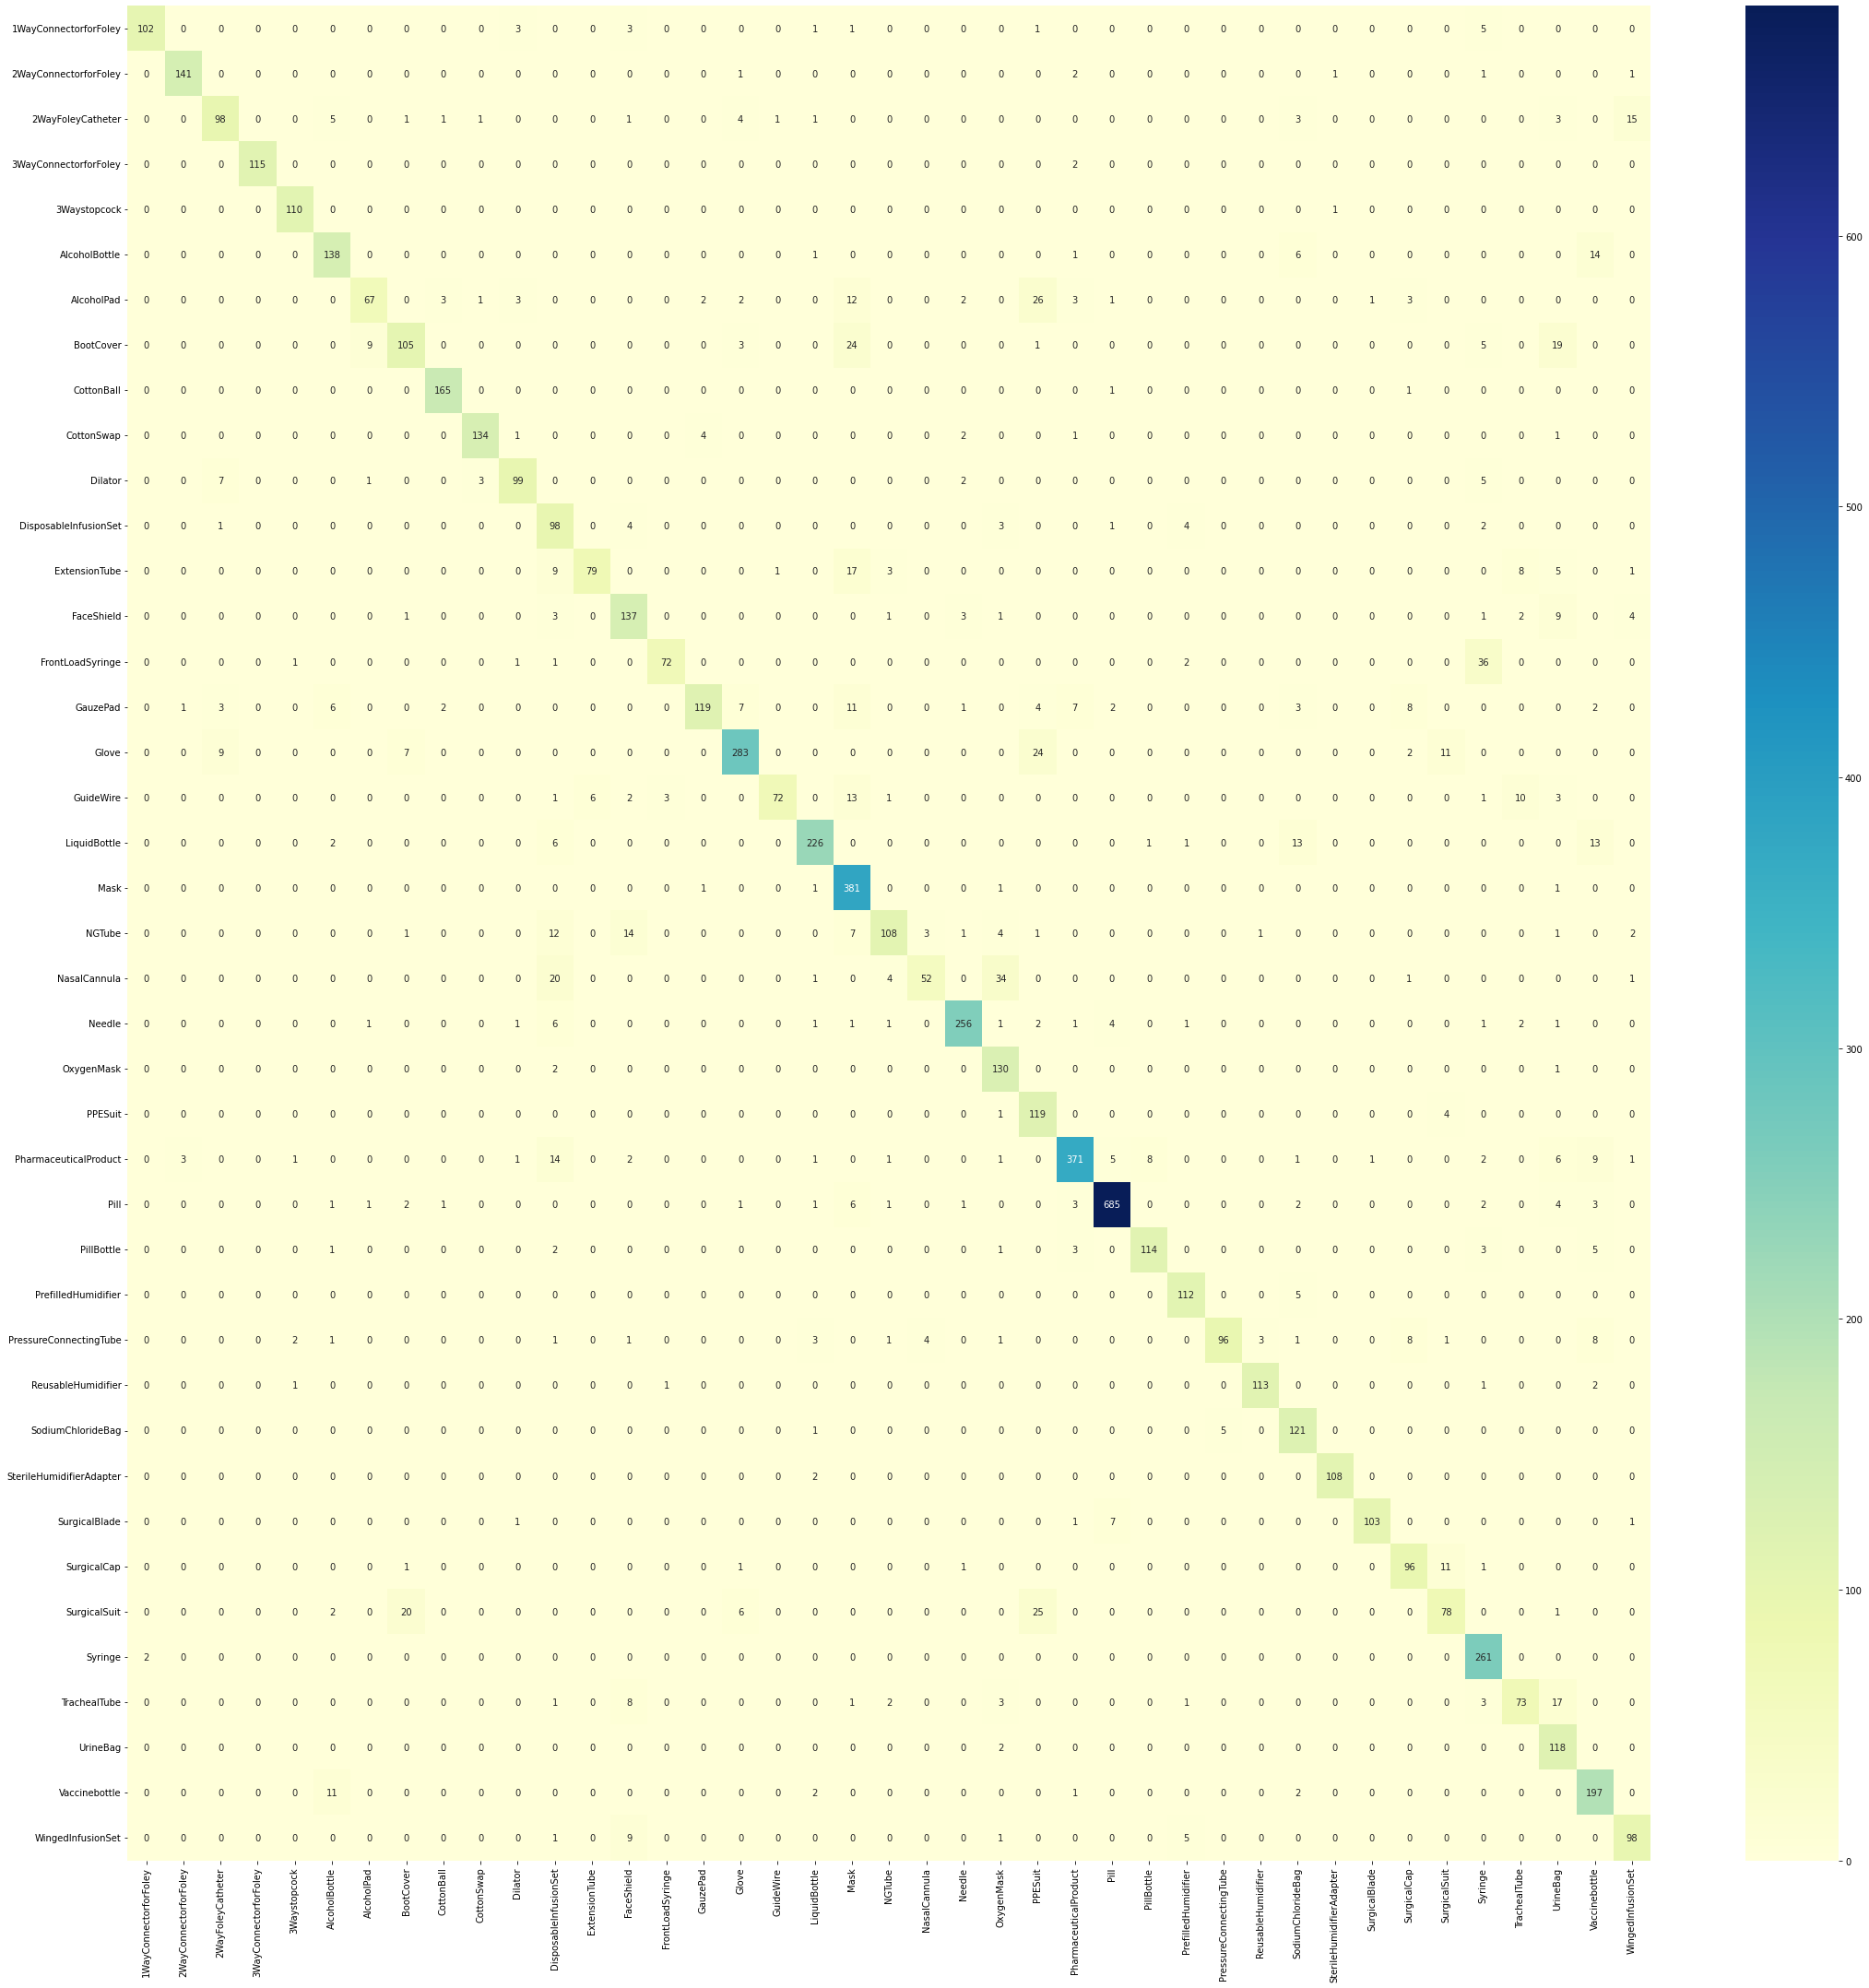

In [7]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMat, index = class_names,
                  columns = class_names)
plt.figure(figsize = (37,37))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt="d")

<AxesSubplot:>

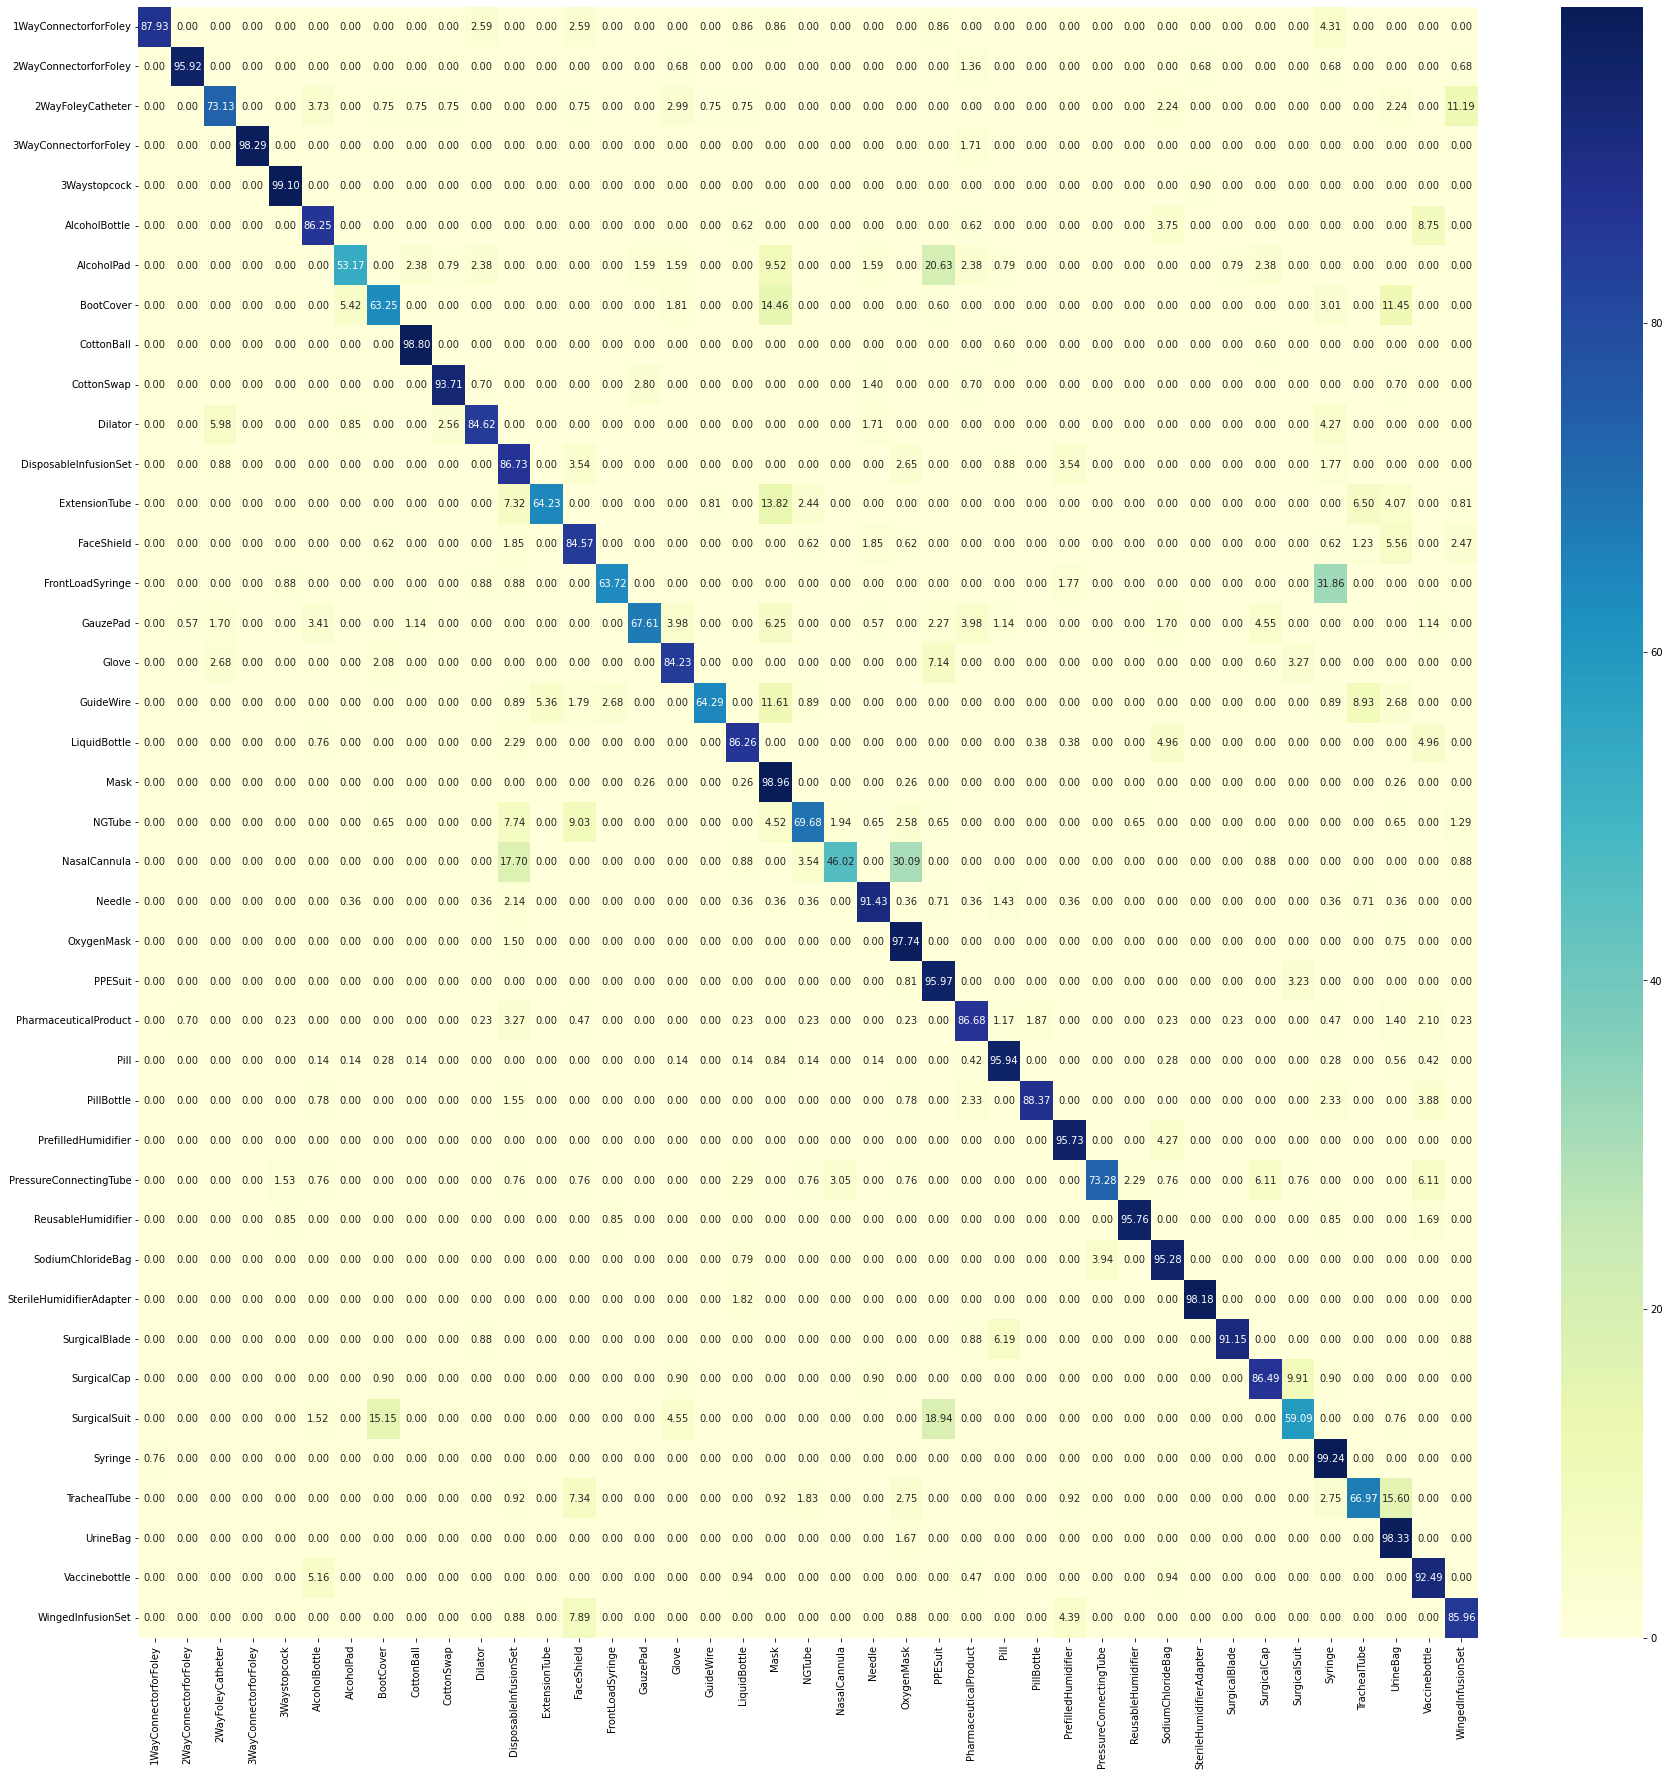

In [8]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMatFloatPercent, index = class_names,
                  columns = class_names)
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt=".2f")